In [1]:
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from mogtrain import MoGTrainer

from tqdm import tqdm_notebook as tqdm

import delfi.distribution as dd

from delfi.utils.viz import probs2contours
%matplotlib inline

In [2]:
example = pickle.load(open('example_2d.pkl', 'rb'))

In [3]:
example

{'comment': 'posterior is (uncorrected * prior) / proposal',
 'posterior': <delfi.distribution.mixture.GaussianMixture.MoG at 0x7f959012f2e8>,
 'prior': <delfi.distribution.Gaussian.Gaussian at 0x7f954ac05710>,
 'proposal': <delfi.distribution.Gaussian.Gaussian at 0x7f954ac05978>,
 'uncorrected': <delfi.distribution.mixture.GaussianMixture.MoG at 0x7f954ac05c50>}

In [4]:
prior = example['prior']
proposal = example['proposal']
uncorrected = example['uncorrected']
post = example['posterior']

In [5]:
class DividedPdf:
    def __init__(self, a, b, norm_region):
        self.a = a
        self.b = b
        
        self.Z = 1
        
        xlist = np.linspace(norm_region[0], norm_region[1], 1000)
        samples = self.eval(xlist.reshape(-1,1), log=False)
        
        dx = xlist[1] - xlist[0]
        
        mass = np.sum(samples) * dx
        self.Z = mass
        
    def eval(self, samples, log=True):
        ret = self.a.eval(samples, log=log) / self.b.eval(samples, log=log)
        return ret / self.Z
    
def divide_dists(a, b, norm_region):
    if isinstance(a, dd.Gaussian) and isinstance(b, dd.Gaussian):
        return a / b
    
    return DividedPdf(a, b, norm_region)

In [6]:
#prior = dd.Gaussian(m=[0], S=[[5]])
#proposal = dd.Gaussian(m=[0], S=[[1]]).convert_to_T(dof=1)
#uncorrected = prior
#posterior = divide_dists(prior * uncorrected, proposal, (-6, 6))

In [7]:
trainer = MoGTrainer(proposal, prior, uncorrected, ncomponents=2, nsamples=10000, lr=0.01, es_thresh=0, es_rounds=250)

losses = trainer.train(nsteps=5000)

pred = trainer.get_mog()

loss=[ 4.9019804]:  25%|██▌       | 1261/5000 [00:13<00:38, 96.79it/s] 

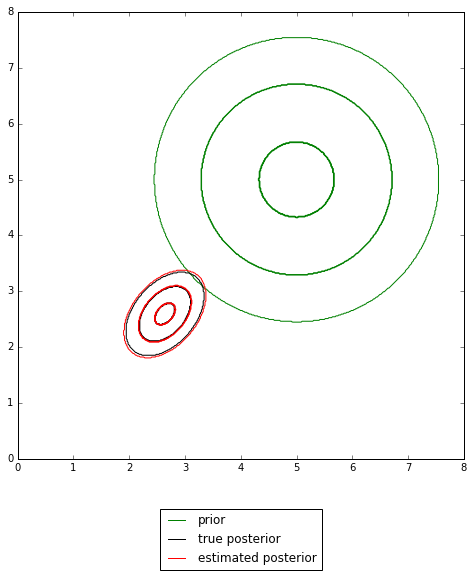

In [8]:
# visualize results if 2D
if len(pred.xs[0].m) == 2:
    res = 500
    xlims = (0, 8)
    ylims = xlims

    xaxis = np.linspace(*xlims, res)
    yaxis = np.linspace(*ylims, res)
    x, y = np.meshgrid(xaxis, yaxis)

    xy = np.concatenate([x.reshape([-1, 1]), 
                         y.reshape([-1, 1])], 
                        axis=1)


    levels = [0.8, 0.5, 0.1]

    prior_contour = probs2contours(prior.eval(xy, log=False), levels).reshape(res, res)
    #like_contour = probs2contours(dist1.eval(xy, log=False), levels).reshape(res, res)
    post_contour = probs2contours(post.eval(xy, log=False), levels).reshape(res, res)
    pred_contour = probs2contours(pred.eval(xy, log=False), levels).reshape(res, res)


    plt.figure(figsize=(8, 8))

    plt.contour(x, y, prior_contour, colors=('g'))
    plt.contour(x, y, post_contour, colors=('k'))
    #plt.contour(x, y, like_contour, colors=('b'))
    plt.contour(x, y, pred_contour, colors=('r'))

    green_line = mlines.Line2D([], [], color='g', label='prior')
    #blue_line = mlines.Line2D([], [], color='b', label='first posterior')
    black_line = mlines.Line2D([], [], color='k', label='true posterior')
    red_line = mlines.Line2D([], [], color='r', label='estimated posterior')
    plt.legend(handles=[green_line, black_line, red_line], 
               loc=9, bbox_to_anchor=(0.5, -0.1))

    plt.show()

In [9]:
# visualize results if 2D
if len(pred.xs[0].m) == 1:
    res = 500
    xlims = (-6, 6)

    xaxis = np.linspace(*xlims, res)
    
    plt.figure(figsize=(8, 8))

    prior_trace = prior.eval(xaxis.reshape((-1,1)), log=False)
    post_trace = post.eval(xaxis.reshape((-1,1)), log=False)
    pred_trace = pred.eval(xaxis.reshape((-1,1)), log=False)
    
    plt.plot(xaxis, prior_trace, color='g', label='prior')
    plt.plot(xaxis, post_trace, color='k', label='true posterior')
    plt.plot(xaxis, pred_trace, color='r', label='estimated posterior')
    
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1))

    plt.show()

loss=[ 4.9019804]:  25%|██▌       | 1261/5000 [00:30<01:29, 41.99it/s]